In [1]:
import pandas as pd
import qgrid
from skimpy import clean_columns
import lightgbm as lgb
import matplotlib as plt
import shap
shap.initjs()

2022-05-12 16:23:10,801 [5991] WARNING  py.warnings:109: [JupyterRequire] /Users/sam/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)

2022-05-12 16:23:10,802 [5991] WARNING  py.warnings:109: [JupyterRequire] /Users/sam/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)

2022-05-12 16:23:10,802 [5991] WARNING  py.warnings:109: [JupyterRequire] /Users/sam/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from p

In [2]:
d_voters_raw = pd.read_excel(
    "../data/nz/elections-nz/2020-General-Election-full-voter-turnout-statistics.xlsx", 
    sheet_name="Voting by age & descent",
    header=4
)

In [3]:
qgrid.show_grid(d_voters_raw, grid_options={'forceFitColumns': False, 'showToolbar': True})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [4]:
# remove "all electorates"
d_voters_proc = clean_columns(d_voters_raw)

In [5]:
qgrid.show_grid(d_voters_proc, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [6]:
# filter for numbered electorates only
d_voters_proc = (
    d_voters_proc
    .loc[pd.to_numeric(d_voters_proc['electorate_number'], errors='coerce').notnull()]
)

In [7]:
qgrid.show_grid(d_voters_proc, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [8]:
# import imd data
d_imd_raw = pd.read_excel("../data/nz/IMD2018.xlsx", sheet_name="IMD18")
d_imd_raw = clean_columns(d_imd_raw)

In [9]:
qgrid.show_grid(d_imd_raw, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [10]:
qgrid.show_grid(d_imd_raw[['ta_2020name', 'rnk_imd_no_inc', 'rank_incom']], grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [11]:
#group by weighted averages
d_imd_proc = (
    d_imd_raw
    .groupby('ged_2020_id')
    .apply(lambda x: pd.Series({
        'population': x['census_18_pop'].sum(),
        'imd_18_dec': np.average(x.dec_imd_18, weights=x.census_18_pop),
        'imd_18_rank': np.average(x.rank_imd_18, weights=x.census_18_pop),
        'emp_dec': np.average(x.decile_emp, weights=x.census_18_pop),
        'emp_rank': np.average(x.rank_emplo, weights=x.census_18_pop),
        'income_dec': np.average(x.decile_inc, weights=x.census_18_pop),
        'income_rank': np.average(x.rank_incom, weights=x.census_18_pop),
        'income_dec_no': np.average(x.rnk_imd_no_inc, weights=x.census_18_pop),
        'health_dec': np.average(x.decile_hea, weights=x.census_18_pop),
        'health_rank': np.average(x.rank_healt, weights=x.census_18_pop),
        'edu_dec': np.average(x.decile_edu, weights=x.census_18_pop),
        'edu_rank': np.average(x.rank_educa, weights=x.census_18_pop)
    }))
)

In [12]:
qgrid.show_grid(d_imd_proc)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [13]:
d_train = (
    d_voters_proc
    .merge(d_imd_proc, how = "left", left_on = "electorate_number", right_on = "ged_2020_id"))

In [14]:
qgrid.show_grid(d_train, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [15]:
#l_features_num = ['imd_18_dec', 'emp_dec', 'income_dec', 'health_dec']
#l_features_cat = ['age_band', 'voter_designation_by_descent']
l_features_num = ['emp_dec', 'income_dec', 'health_dec', 'edu_dec']
l_features_cat = ['voter_designation_by_descent', 'age_band']
l_target = ['voters_as_%_of_total_enrolled']
d_weight = d_train['total_enrolled']
l_all = l_features_num + l_features_cat

In [16]:
d_train[l_all].dtypes

emp_dec                         float64
income_dec                      float64
health_dec                      float64
edu_dec                         float64
voter_designation_by_descent     object
age_band                         object
dtype: object

In [17]:
for c in l_features_cat:
    d_train[c] = d_train[c].astype('category')

In [18]:
lgb_train = lgb.Dataset(
    data = d_train[l_all], 
    categorical_feature = l_features_cat,
    label = d_train[l_target],
    weight = d_weight,
    free_raw_data=False
)

In [19]:
lgb_param = {
    'num_leaves': 10, 
    'learning_rate': 0.2,
    'num_iterations': 50,
    'objective': 'regression', 
    'metric': 'mae',
    'verbose_eval': 1}

In [20]:
lgb_mod = lgb.train(
    params = lgb_param, 
    train_set = lgb_train, 
    valid_names=[lgb_train], 
    categorical_feature=l_features_cat,
    verbose_eval = 1)

2022-05-12 16:23:23,626 [5991] WARNING  py.warnings:109: [JupyterRequire] Found `num_iterations` in params. Will use it instead of argument

2022-05-12 16:23:23,629 [5991] WARNING  py.warnings:109: [JupyterRequire] 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1507, number of used features: 6
[LightGBM] [Info] Start training from score 0.815445


In [21]:
# predict, print error
d_out = d_train
d_out['preds'] = lgb_mod.predict(d_train[l_all])
d_out['error'] = np.abs(d_out['preds'] - d_out['voters_as_%_of_total_enrolled'])
np.sum(d_out['error'])

26.634816013758517

In [29]:
# TO DO: Proper tuning + validation using CV
#lgb.cv(lgb_param, lgb_train, nfold=5, stratified=False)

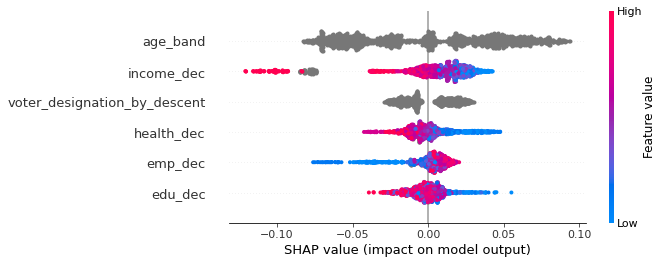

In [30]:
shap_values = shap.TreeExplainer(lgb_mod).shap_values(d_train[l_all])
shap.summary_plot(shap_values, d_train[l_all])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

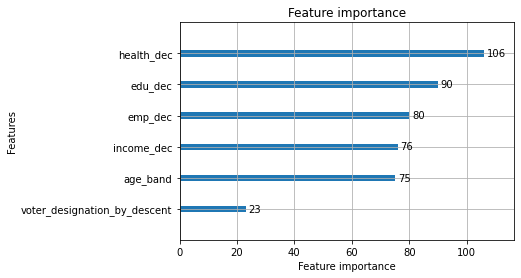

In [31]:
lgb.plot_importance(lgb_mod)

In [32]:
d_preds = lgb_mod.predict(d_train[l_all], pred_contrib=True)

<AxesSubplot:title={'center':'Split value histogram for feature with name edu_dec'}, xlabel='Feature split value', ylabel='Count'>

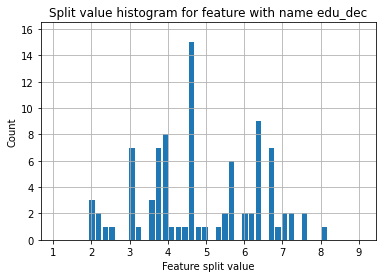

In [33]:
lgb.plot_split_value_histogram(lgb_mod, feature ='edu_dec')

<AxesSubplot:>

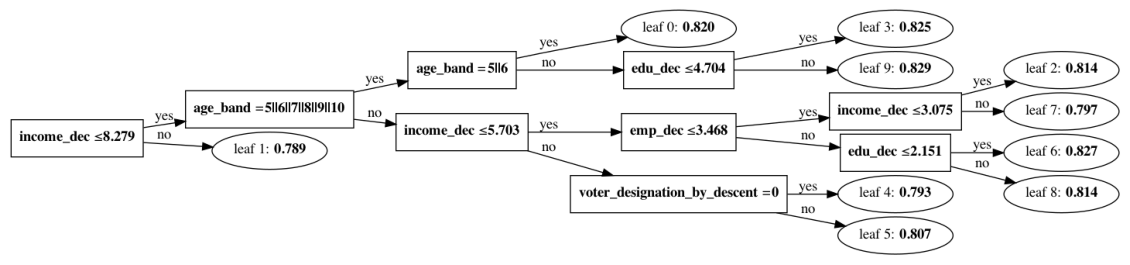

In [34]:
lgb.plot_tree(lgb_mod, tree_index = 0, figsize=(20,10))

In [35]:
# Useful tuning plot - doesn't work though??
#lgb.plot_metric(lgb_mod)

In [36]:
qgrid.show_grid(d_out, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

2022-05-12 16:25:55,464 [5991] WARNING  py.warnings:109: [JupyterRequire] Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



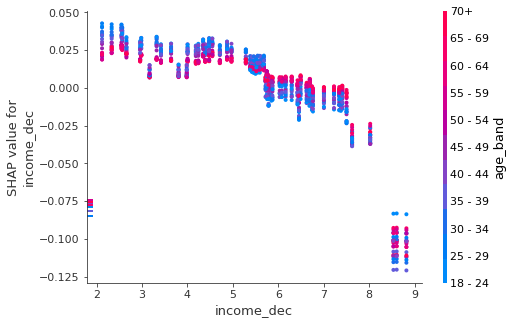

In [37]:
shap.dependence_plot("income_dec", shap_values, d_train[l_all])

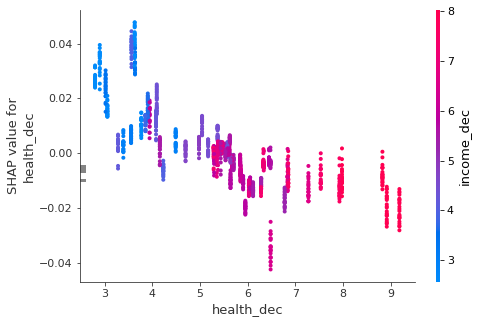

In [38]:
shap.dependence_plot("health_dec", shap_values, d_train[l_all])

In [40]:
d_out['preds'][0]

0.8625475247105588

In [304]:
qgrid.show_grid(d_out, grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [42]:
d_train_out = d_train[l_all] #pandas getting me good, TO DO: tidy this 

In [44]:
#SHAP for individual observations - this is the money plot to show the interpendence between factors
i_selector = 0 # choose a row in training set
# TO DO: Add a title based on the row selected (e.g. Electorate/Ethnicity etc)
shap.force_plot(d_out['preds'][i_selector], shap_values[i_selector], d_train_out.iloc[i_selector,:])